## Neural network classification for the jet dataset

Importing the NeuralNet library.

In [3]:
library(neuralnet)

Importing the dataset:

In [ ]:
df <- read.csv('./../dataSaoPaulo2018/data/event-0005.csv')

One hot encoding the target attribute:

In [74]:
df$group0 <- df$jet == 0
df$group1 <- df$jet == 1
df$group2 <- df$jet == 2

Head of the end result of manipulation:

In [75]:
head(df)

jet,constituent,eta,phi,px,py,pz,p,vjet,group0,group1,group2
0,0,-0.456679,-1.769878,-0.178798,-0.886218,-0.427374,788.651301,NaN,TRUE,FALSE,FALSE
0,1,-0.451003,-1.770757,-0.180011,-0.888201,-0.422723,234.618344,NaN,TRUE,FALSE,FALSE
0,2,-0.455031,-1.657863,-0.078671,-0.901284,-0.426026,122.207524,NaN,TRUE,FALSE,FALSE
0,3,-0.452284,-1.651613,-0.073121,-0.902811,-0.423775,99.432245,NaN,TRUE,FALSE,FALSE
0,4,-0.446974,-1.658059,-0.079116,-0.904343,-0.419409,91.636616,NaN,TRUE,FALSE,FALSE
0,5,-0.452834,-1.767828,-0.177271,-0.888036,-0.424225,54.524478,NaN,TRUE,FALSE,FALSE


Sampling randomly the dataset without replacement to create the train and test set (80/20% ratio):

In [135]:
smpl <- sample(nrow(df),nrow(df)*0.8)
dfTrain <- df[smpl,c(1,3:4,10:12)]
dfTest <- df[-smpl,c(1,3:4,10:12)]

Training the neural network. We used 10 neurons in the hidden layer:

In [144]:
nn <- neuralnet(group0 + group1 + group2 ~ eta + phi, data = dfTrain, rep=15, hidden = c(10))

Plotting the best network:

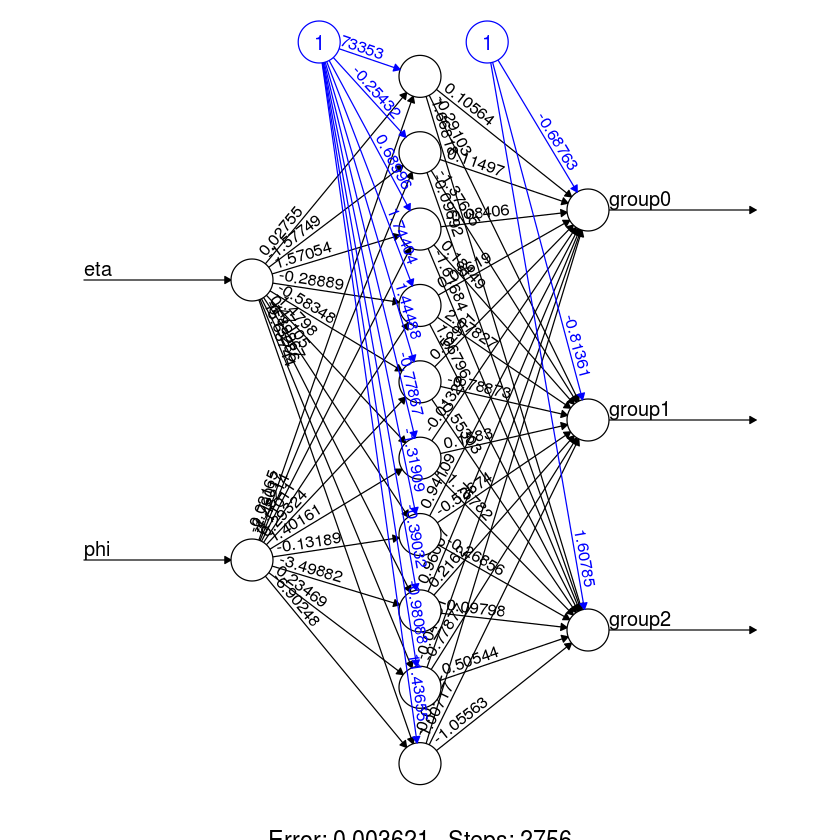

In [145]:
plot(nn, rep= "best")

Gives the best number of best repetition:

In [146]:
which.min(nn$result.matrix[1,])

15 
15

Makes predictions using the best NN model (associated with the repetition number given above):

In [147]:
predictions <- compute(nn, dfTest[2:3], rep = which.min(nn$result.matrix[1,]))

For each row, with the three dummy variables created above during the one hot encoding step, retrieve the index of the column with the highest value and subtract one, so it matches the 0-2 range of the original label column (jet):

In [148]:
finalpreds <- apply(predictions$net.result, 1, which.max)

# Assessment of models

As a first assessment of the classification above, generate the confusion matrix:

In [149]:
table(finalpreds-1, dfTest$jet)

   
     0  1  2
  0  6  0  0
  1  0 22  0
  2  0  0 13

There's probably a better way to do this, but this was the quickest way I was able to compute the accuracy from the confusion matrix above. First compute the sum of the offdiagonal elements (false predictions):
   

In [150]:
offdiag <- sum(table(finalpreds-1, dfTest$jet)[lower.tri(table(finalpreds-1, dfTest$jet))])+sum(table(finalpreds-1, dfTest$jet)[upper.tri(table(finalpreds-1, dfTest$jet))])

In [151]:
accuracy <- 1/(1+offdiag/sum(diag(table(finalpreds-1, dfTest$jet))))
accuracy #100% accuracy

[1] 1

As one can see, predictions are perfect since the data is linearly separable (already known from our previous analysis).

Now let's perform crossvalidation, to check the performance of our code:

In [187]:
#Randomly shuffle the data
df<-df[sample(nrow(df)),]

#Create 10 equally size folds
folds <- cut(seq(1,nrow(df)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(j in seq(1,10)){
    
    #assigns 0 to the average accuracy variable
    avaccuracy <- 0
    
    for(i in 1:10){
        #Segements the data by fold using the which() function 
        testIndexes <- which(folds==i,arr.ind=TRUE)
        dfTest <- df[testIndexes, c(1,3:4,10:12)]
        dfTrain <- df[-testIndexes, c(1,3:4,10:12)]
        #Trains the data using the same setup discussed above
        #we vary the number of neurons in the hidden layer, j counter
        nn <- neuralnet(group0 + group1 + group2 ~ eta + phi, data = dfTrain, rep=10, hidden = j)
        #This chunk computes the accuracy of the model
        predictions <- compute(nn, dfTest[2:3], rep = which.min(nn$result.matrix[1,]))
        finalpreds <- apply(predictions$net.result, 1, which.max)
        offdiag <- sum(table(finalpreds-1, dfTest$jet)[lower.tri(table(finalpreds-1, dfTest$jet))])+sum(table(finalpreds-1, dfTest$jet)[upper.tri(table(finalpreds-1, dfTest$jet))])
        accuracy <- 1/(1+offdiag/sum(diag(table(finalpreds-1, dfTest$jet))))

        #computes average accuracy
        avaccuracy <- avaccuracy + accuracy/10

        #computes the average confusion matrix
        if(i == 1){
            confmatrix <- table(finalpreds-1, dfTest$jet)
        }else{
            confmatrix <- confmatrix + table(finalpreds-1, dfTest$jet)
        }

    }
    print("Neurons in the hidden layer")
    print(j)
    print(avaccuracy)
    print(confmatrix)
}

[1] "Neurons in the hidden layer"
[1] 1
[1] 0.01
   
     0  1  2
  1  1 90  0
  2 45  1 68
[1] "Neurons in the hidden layer"
[1] 2
[1] 0.995
   
     0  1  2
  0 46  0  0
  1  0 90  0
  2  0  1 68
[1] "Neurons in the hidden layer"
[1] 3
[1] 0.995
   
     0  1  2
  0 46  0  0
  1  0 90  0
  2  0  1 68
[1] "Neurons in the hidden layer"
[1] 4
[1] 1
   
     0  1  2
  0 46  0  0
  1  0 91  0
  2  0  0 68
[1] "Neurons in the hidden layer"
[1] 5
[1] 1
   
     0  1  2
  0 46  0  0
  1  0 91  0
  2  0  0 68
[1] "Neurons in the hidden layer"
[1] 6
[1] 0.995
   
     0  1  2
  0 45  0  0
  1  1 91  0
  2  0  0 68
[1] "Neurons in the hidden layer"
[1] 7
[1] 1
   
     0  1  2
  0 46  0  0
  1  0 91  0
  2  0  0 68
[1] "Neurons in the hidden layer"
[1] 8
[1] 0.995
   
     0  1  2
  0 46  1  0
  1  0 90  0
  2  0  0 68
[1] "Neurons in the hidden layer"
[1] 9
[1] 0.995
   
     0  1  2
  0 46  0  0
  1  0 90  0
  2  0  1 68
[1] "Neurons in the hidden layer"
[1] 10
[1] 0.995
   
     0  1  2
  0 

From the above analysis we can see that above 2 neurons in the hidden layer is more than enough to give an almost perfect prediction. We assessed the quality of the models by computing the average accuracy over the 10 models for the 10 fold cross-validation. We also show the confusion matrix. Architectures with 4 to 7 neurons in the hidden layer worked slightly even better than the ones with more neurons, although this may be just an artifact since the difference in performance doesn't seem to be very significant.